In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
import pandas as pd
import cv2

In [3]:
# custom dataset
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, filepath, train=True, transform=None):
        
        label_csv = pd.read_csv(Path(filepath) / 'labels.csv')
        data_split = label_csv[label_csv['train'] == train]
                
        imgs = []
        for i, spot in data_split.iterrows():
            if spot["label"] == "-":
                continue
            img = cv2.imread(spot["filepath"])
            imgs.append(img[..., 0].reshape(1, 48, 48) / 255.0)
        
        data_points = data_split[data_split["label"] != "-"]
        labels = np.array([int(label) for label in data_points["label"]])
                
        self.data = torch.tensor(np.array(imgs), dtype=torch.float32)
        self.target = torch.tensor(labels - 1, dtype=torch.long)
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx], self.target[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
fp = Path(r"D:\Tracking\NucleiTracking\data\processed\embryo014a")
train_dataset = CustomDataset(fp)
test_dataset = CustomDataset(fp, train=False)

In [4]:
# basic transforms
from torchvision.transforms import v2
from torchvision.transforms import functional as F

n_classes = 5
   
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        image, target = sample
        return F.normalize(image, self.mean, self.std), target

class OneHot(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        
    def __call__(self, sample):
        image, target = sample
        return image, torch.nn.functional.one_hot(target, self.n_classes)


test_transform = v2.Compose([
    Normalize((0.5,), (0.5,))
])

train_transform = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    Normalize((0.5,), (0.5,))
])

train_dataset = CustomDataset(fp, transform=train_transform)
test_dataset = CustomDataset(fp, train=False, transform=test_transform)

In [5]:
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

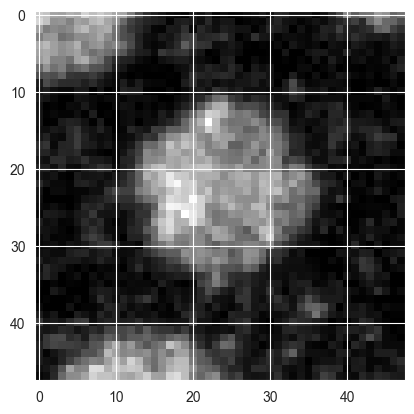

tensor(1)


In [6]:
# visualise
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5
    
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap='gray')
    plt.show()
    
dataiter = iter(train_loader)

images, labels = list(dataiter)[0]

imshow(images[0])
print(labels[0])

In [7]:
# input shape: (batch_size, 1, 48, 48)

# set up cnn
# four layers of downsampling, with increasing number of filters
# followed by two fully connected layers

filters = [16, 32, 64, 128]
n_classes = 5

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, filters[0], 3, padding=1)
        self.convs = nn.ModuleList([nn.Conv2d(filters[i], filters[i+1], 3, padding=1) for i in range(len(filters)-1)])
        self.fc1 = nn.Linear(128*6*6, 64)
        self.fc2 = nn.Linear(64, n_classes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        for conv in self.convs:
            x = self.relu(conv(x))
            x = self.maxpool(x)
        x = x.view(-1, 128*6*6)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
cnn = CNN() 


In [8]:
# loss and optimiser
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.25, momentum=0.01)

In [9]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = cnn(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

    return running_loss

In [10]:
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    cnn.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    cnn.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            voutputs = cnn(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    # if avg_vloss < best_vloss:
    #     best_vloss = avg_vloss
    #     model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    #     torch.save(cnn.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
LOSS train 10.970054149627686 valid 1.4801206588745117
EPOCH 2:
LOSS train 10.494818806648254 valid 1.5057216882705688
EPOCH 3:
LOSS train 10.464279651641846 valid 1.4925928115844727
EPOCH 4:
LOSS train 10.38901662826538 valid 1.4505900144577026
EPOCH 5:
LOSS train 10.379851698875427 valid 1.5373985767364502
EPOCH 6:
LOSS train 10.431451678276062 valid 1.4863004684448242
EPOCH 7:
LOSS train 10.360496282577515 valid 1.475830078125
EPOCH 8:
LOSS train 10.387738823890686 valid 1.4756135940551758
EPOCH 9:
LOSS train 10.298068284988403 valid 1.4828516244888306
EPOCH 10:
LOSS train 10.34169352054596 valid 1.456156849861145
EPOCH 11:
LOSS train 10.283531188964844 valid 1.454601764678955
EPOCH 12:
LOSS train 10.246004223823547 valid 1.4452327489852905
EPOCH 13:
LOSS train 10.109243035316467 valid 1.4327212572097778
EPOCH 14:
LOSS train 9.974164724349976 valid 1.3379888534545898
EPOCH 15:
LOSS train 9.770097255706787 valid 1.2931978702545166
EPOCH 16:
LOSS train 9.667371153831482 valid

In [11]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cnn.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for i, data in enumerate(train_loader):
        inputs, labels = data
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())
        
confusion_matrix(y_true, y_pred)

array([[103,   1,   0,   4,   0],
       [  1,  68,  11,   1,   0],
       [  0,   0, 107,   5,   0],
       [  2,   0,   9, 103,   0],
       [  1,   1,   1,   3,   7]], dtype=int64)